<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Inference_with_TrOCR_%2B_Gradio_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

We install 🤗 Transformers, which includes many awesome models, including TrOCR by Microsoft Research.

In [1]:
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 9.5 MB/s 
     |████████████████████████████████| 895 kB 61.1 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 46.6 MB/s 


## Load image

Here we load an image from the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), on which TrOCR was fine-tuned.

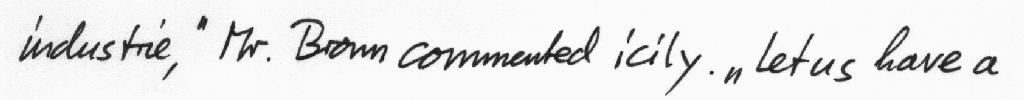

In [2]:
import requests
from PIL import Image

url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

## Prepare image for model

Next, we use `TrOCRProcessor` (which wraps a `ViTFeatureExtractor` and a `RobertaTokenizer` into one) to resize + normalize the image for the model.

In [3]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# calling the processor is equivalent to calling the feature extractor
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

torch.Size([1, 3, 384, 384])


## Load model

Here we load a TrOCR model from the [hub](https://huggingface.co/models?other=trocr). TrOCR models are instances of [`VisionEncoderDecoderModel`](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder), which combine a vision encoder (like ViT, BEiT, DeiT, ...) with a language model as decoder (like BERT, RoBERTa, GPT-2, ...). 

In [4]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Generate text 

Finally, we can generate text autoregressively using the `.generate()` method. We use the tokenizer part of the `processor` to decode the generated id's back to text. Note that by default, greedy search is used for generation, but there are more fancy methods like beam search and top-k sampling, which are also supported. You can check out [this blog post](https://huggingface.co/blog/how-to-generate) for details.

In [6]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


industry, " Mr. Brown commented icily. " Let us have a


## Gradio demo

We can also wrap up everything we wrote above in a quick [Gradio](https://gradio.app/) demo. Gradio is an awesome tool for creating quick ML demos!

We just need to define a function that takes in an image input and produces a text output (note that Gradio supports many other input & output formats)!

In [7]:
!pip install -q gradio

     |████████████████████████████████| 2.9 MB 7.6 MB/s 
     |████████████████████████████████| 1.1 MB 40.7 MB/s 
     |████████████████████████████████| 253 kB 54.7 MB/s 
     |████████████████████████████████| 2.0 MB 41.3 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 211 kB 64.0 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 144 kB 36.1 MB/s 
     |████████████████████████████████| 271 kB 42.0 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
     |████████████████████████████████| 58 kB 6.6 MB/s 
     |████████████████████████████████| 10.9 MB 28.0 MB/s 
     |████████████████████████████████| 79 kB 8.4 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 3.6 MB 39.8 MB/s 
     |████████████████████████████████| 61 kB 618 kB/s 
     |████████████████████████

In [ ]:
import gradio as gr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# load image examples from the IAM database
urls = ['https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg', 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSoolxi9yWGAT5SLZShv8vVd0bz47UWRzQC19fDTeE8GmGv_Rn-PCF1pP1rrUx8kOjA4gg&usqp=CAU',
        'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRNYtTuSBpZPV_nkBYPMFwVVD9asZOPgHww4epu9EqWgDmXW--sE2o8og40ZfDGo87j5w&usqp=CAU']
for idx, url in enumerate(urls):
  image = Image.open(requests.get(url, stream=True).raw)
  image.save(f"image_{idx}.png")

def process_image(image):
    # prepare image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # generate (no beam search)
    generated_ids = model.generate(pixel_values)

    # decode
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

title = "Interactive demo: TrOCR"
description = "Demo for Microsoft's TrOCR, an encoder-decoder model consisting of an image Transformer encoder and a text Transformer decoder for state-of-the-art optical character recognition (OCR) on single-text line images. This particular model is fine-tuned on IAM, a dataset of annotated handwritten images. To use it, simply upload an image or use the example image below and click 'submit'. Results will show up in a few seconds."
article = "<p style='text-align: center'><a href='https://arxiv.org/abs/2109.10282'>TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models</a> | <a href='https://github.com/microsoft/unilm/tree/master/trocr'>Github Repo</a></p>"
examples =[["image_0.png"], ["image_1.png"], ["image_2.png"]]

iface = gr.Interface(fn=process_image, 
                     inputs=gr.inputs.Image(type="pil"), 
                     outputs=gr.outputs.Textbox(),
                     title=title,
                     description=description,
                     article=article,
                     examples=examples)
iface.launch(debug=True)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://46686.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
